In [91]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from Bio.SeqIO.FastaIO import SimpleFastaParser

#run_type = "dry"
run_type = "wet"


new_day = datetime.datetime.now().strftime("%Y%m%d")

palette = {"DR_lifelong":"red", "AL_lifelong":"dodgerblue", 
           "AL_DR16M":"teal", "AL_DR20M":"gold", "Food":"brown"}
path = "../analysis/plots/deseq_timepoints/"

In [92]:
m5 = pd.read_csv("../analysis/deseq_timepoints/ALDR_5M_20210901.csv", sep = ";")
m20 = pd.read_csv("../analysis/deseq_timepoints/ALDR_20M_20210901.csv", sep = ";")
m24 = pd.read_csv("../analysis/deseq_timepoints/ALDR_24M_20210901.csv", sep = ";")

mat = pd.concat([m5, m20, m24], 
                keys = [5, 20, 24])
mat.reset_index(inplace = True)
mat.columns = ["Months", "trash", "sequence", 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
mat.drop(columns = ["trash"], inplace = True)
# Make a tax column to compare to lefse
mat["tax"] = mat[["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].astype(str).agg("_".join, axis = 1)
mat["tax"] = list(mat["tax"].str.replace("_nan", "_NA"))

In [93]:
# Read fasta with ASV names to put OTU into our dataframe
with open('../analysis/seqtab_merge3/mergedQC/CLEAN_ASVs_merged_20210215.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID
        seqs.append(sequence)

fasta_tuples = list(zip(identifiers, seqs))
df_fa = pd.DataFrame(fasta_tuples, columns = ["OTU", "sequence"])

In [94]:
# Merge into our matrix with FC and stuff
mer = pd.merge(mat, df_fa, how = "left", on = "sequence")

dfpl = mer.loc[:, ["Months", "log2FoldChange", "OTU"]].pivot_table(index = "OTU", 
                    columns = "Months", values = "log2FoldChange")
dfpl.fillna(0, inplace = True)
dfpl = dfpl.reset_index()

In [95]:
print(f"ALDR 5M: {(dfpl[5]!=0).sum()}")
print(f"ALDR 20M: {(dfpl[20]!=0).sum()}")
print(f"ALDR 24M: {(dfpl[24]!=0).sum()}")

ALDR 5M: 20
ALDR 20M: 79
ALDR 24M: 39


In [96]:
dfam = pd.DataFrame({"DR_lifelong": [20, 79, 39],
                    "AL_DR16M": [0, 94, 39], 
                    "AL_DR20M": [0, 0, 34]})
dfam = dfam.T
dfam = dfam.reset_index()
dfam.columns = ["Treatment", "5", "20", "24"]

dfam = pd.melt(dfam, id_vars=['Treatment'], value_vars=['5', "20", "24"],
         var_name='Months', value_name='values')

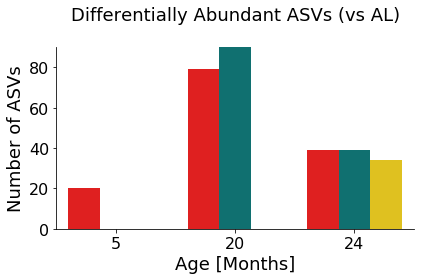

In [101]:
fig, ax = plt.subplots(figsize = (6, 4))
a = sns.barplot(data = dfam, hue = "Treatment", x = "Months", y = 'values', 
            order = ["5", "20", "24"], palette = palette)
a.legend_.remove()
ax.tick_params(axis = "x", labelsize=16)
ax.tick_params(axis = "y", labelsize=16)
ax.set_xlabel("Age [Months]", fontsize = 18)
ax.set_ylabel("Number of ASVs", fontsize = 18)
plt.title("Differentially Abundant ASVs (vs AL)\n", fontsize = 18)
plt.ylim(0, 90)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()

if run_type != "dry":
    plt.savefig(path + "NumASVs_vsAL_{}.pdf".format(new_day))
else:
    plt.show()

In [99]:
dfamDR = pd.DataFrame({"AL_lifelong": [20, 79, 39],
                    "AL_DR16M": [0, 15, 29], 
                    "AL_DR20M": [0, 0, 15]})
dfamDR = dfamDR.T
dfamDR = dfamDR.reset_index()
dfamDR.columns = ["Treatment", "5", "20", "24"]

dfamDR = pd.melt(dfamDR, id_vars=['Treatment'], value_vars=['5', "20", "24"],
         var_name='Months', value_name='values')

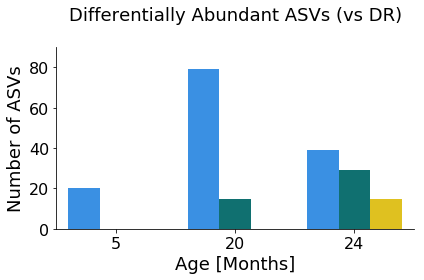

In [102]:
fig, ax = plt.subplots(figsize = (6, 4))
a = sns.barplot(data = dfamDR, hue = "Treatment", x = "Months", y = 'values', 
            order = ["5", "20", "24"], palette = palette)
a.legend_.remove()
ax.tick_params(axis = "x", labelsize=16)
ax.tick_params(axis = "y", labelsize=16)
ax.set_xlabel("Age [Months]", fontsize = 18)
ax.set_ylabel("Number of ASVs", fontsize = 18)
plt.title("Differentially Abundant ASVs (vs DR)\n", fontsize = 18)
plt.ylim(0, 90)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()

if run_type != "dry":
    plt.savefig(path + "NumASVs_vsDR_{}.pdf".format(new_day))
else:
    plt.show()